In [1]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import math
import sequtils as sue
from scipy.stats import linregress

In [2]:
dataset_name = 'SEAsia_stiffness2'
out_path = '../../data/frequencies/regions/'
frequencies = pd.read_csv('../../data/frequencies/regions/seAsia_stiffness2_pivots4.csv', index_col=0)
frequencies.drop([gt for gt in frequencies.columns.values if 'SYLVATIC' in gt], inplace=True, axis=1)
all_genotypes = frequencies.columns.values
max_freqs = frequencies.max() # only look at genotypes that have circulated at >= 10% frequency at some point in time
present_genotypes = [g for g in all_genotypes if max_freqs[g] >= 0.1]

titer_path = '../../data/katzelnick2015/processed/genotypes_dTiters.csv'
print frequencies.head()

           DENV1_I  DENV1_II  DENV1_IV  DENV1_V  DENV2_AMERICAN  \
1970.1667   0.0245    0.0587    0.0040   0.1279             0.0   
1970.4167   0.0232    0.0504    0.0038   0.1383             0.0   
1970.6667   0.0216    0.0430    0.0036   0.1484             0.0   
1970.9167   0.0199    0.0360    0.0033   0.1573             0.0   
1971.1667   0.0209    0.0346    0.0034   0.1939             0.0   

           DENV2_ASIANAMERICAN  DENV2_ASIANI  DENV2_ASIANII  \
1970.1667               0.1678        0.1268         0.0150   
1970.4167               0.1554        0.1174         0.0139   
1970.6667               0.1430        0.1080         0.0128   
1970.9167               0.1306        0.0987         0.0117   
1971.1667               0.1263        0.0955         0.0113   

           DENV2_COSMOPOLITAN  DENV3_I  DENV3_II  DENV3_III  DENV3_V  DENV4_I  \
1970.1667              0.0051      0.0    0.0238     0.0071   0.0050   0.0089   
1970.4167              0.0047      0.0    0.0235     0.0

In [3]:
dTiters = pd.read_csv(titer_path, index_col=0, header=None, names=['gt1', 'gt2', 'dTiter'])
titers = {}
for idx, i in dTiters.iterrows():
    key = tuple(sorted([i['gt1'], i['gt2']]))
    titers[key] = i['dTiter']

In [8]:
def are_cocirculating((g1, g2), row):
    return row[g1] >= 0.1 and row[g2] >= 0.1

def find_cocirculation_events(time_boolean_series):
    ''' input like: pd.Series([True, True, True, False, False, ...], index=[1980,1981,1982,...])
        where True indicates a season where two genotypes were cocirculating (both >= 10% frequency)
        output like: [(1980,1930)]
        list of tuples of each contiguous time period wherein g1 and g2 were continuously cocirculating
    '''
    # Start dates: where cocirculating = True in this season, but the preceeding season was False
    cocirculation_start_dates = time_boolean_series.index[time_boolean_series & ~ time_boolean_series.shift(1).fillna(False)]
    # End dates: where cocirculating = False, but the preceeding season was True
    cocirculation_end_dates = time_boolean_series.index[time_boolean_series & ~ time_boolean_series.shift(-1).fillna(False)]
    
    time_periods = zip(cocirculation_start_dates, cocirculation_end_dates)
    return time_periods
        
def get_years_between(time_periods):
    yb = []
    
    if len(time_periods) < 2:
        return np.nan
    for i in range(len(time_periods)-1):
        end1 = time_periods[i][1]
        start2 = time_periods[i+1][0]
        yb.append(start2 - end1)
        
    return float(sum(yb)) / float(len(yb))

    
def get_avg_len_cocirculating(time_periods):
    ''' input like: [(1980,1985), (1991,1992)]'''
    if len(time_periods) == 0:
        return 0.
    len_cocirculating = [end - start for start,end in time_periods]
    return float(sum(len_cocirculating)) / float(len(len_cocirculating))

def get_competitive_exclusion((g1,g2), time_periods, frequencies, years_forward=2):
    outcomes = []
    all_pivots = frequencies.index.tolist()
    
    for (start, end) in time_periods:
        
        if end > frequencies.index.max() - years_forward: # not enough data
            break
        
        end_idx = all_pivots.index(end)
        end_dt = all_pivots[end_idx+1]
        
        g1_extinct = frequencies[g1][end_dt] < 0.1
        g2_extinct = frequencies[g2][end_dt] < 0.1
        delta_g1 = frequencies[g1][end_dt+years_forward] - frequencies[g1][end_dt]
        delta_g2 = frequencies[g2][end_dt+years_forward] - frequencies[g2][end_dt]
                
        if g1_extinct and g2_extinct: # mutual extinction
            outcomes.append(False)
        elif g1_extinct:
            if delta_g2 >= 0.:
                outcomes.append(g2) # g2 was succeeding while g1 died out
            else:
                outcomes.append(False) # g2 was on its way out, too
        elif g2_extinct:
            if delta_g1 >= 0.: # g1 was succeeding while g2 died out
                outcomes.append(g1)
            else:
                outcomes.append(False) # g1 was on its way out, too
        else:
            raise ValueError
            
    return outcomes # [g1,g1,False,g2,False,g1] (winning genotype or False if mutual extinction)
    
def get_cocirculation_outcomes(genotypes=present_genotypes, frequencies=frequencies, years_forward=2):
    genotype_pairs = combinations(genotypes, 2)
    
    cocirculation_stability = {}
    competitive_exclusion = {}
    years_between = {}
    
    for (g1,g2) in genotype_pairs:
        key = tuple(sorted([g1,g2]))
        cocirculating_bool = frequencies.apply(lambda x: are_cocirculating(key,x), axis=1) # are they cocirculating?
        time_periods = find_cocirculation_events(cocirculating_bool) # [(start,end), (start,end)]
        cocirculation_stability[key] = get_avg_len_cocirculating(time_periods) # how stable is cocirculation?
        years_between[key] = get_years_between(time_periods)
        competitive_exclusion[key] = get_competitive_exclusion(key,time_periods, frequencies, years_forward) # competitive exclusion or mutual extinction? which genotype won?
    return {'cocirculation_stability': cocirculation_stability, 
            'competitive_exclusion': competitive_exclusion,
           'years_between': years_between}
    
def p_exclusion(competitive_exclusion):
    # Proportion of events where competitive exclusion occurred
    if len(competitive_exclusion) == 0:
        return np.nan
    else:
        return 1. - float(competitive_exclusion.count(False))/float(len(competitive_exclusion))

def p_g1(g1, competitive_exclusion):
    if len(competitive_exclusion) == 0:
        return np.nan
    else:
        n_competitive_exclusion_events = float(len([i for i in competitive_exclusion if i != False]))
        if n_competitive_exclusion_events == 0:
            return np.nan
        else:
            n_g1 = float(competitive_exclusion.count(g1))
            return n_g1 / n_competitive_exclusion_events

In [10]:
cocirculation_outcomes = get_cocirculation_outcomes()
cocirculation_stability = cocirculation_outcomes['cocirculation_stability']
competitive_exclusion = cocirculation_outcomes['competitive_exclusion']
years_between = cocirculation_outcomes['years_between']

genotype_combinations = [tuple(sorted([g1,g2])) for (g1,g2) in combinations(present_genotypes, 2)]

outcomes_df = { 'genotypes': genotype_combinations, # (g1,g2)
                'homotypic': [g1.split('_')[0] == g2.split('_')[0] for (g1,g2) in genotype_combinations], # are g1 and g2 in the same serotype 
                'dTiter': [titers[g] for g in genotype_combinations], # dTiter distance between g1 and g2
                'cocirculation_stability': [cocirculation_stability[g] for g in genotype_combinations], # Avg length of time g1 and g2 stably cocirculate
                'p(exclusion)': [p_exclusion(competitive_exclusion[g]) for g in genotype_combinations], # Proportion of events where competitive exclusion occurred
                'p(g1)': [p_g1(g1, competitive_exclusion[(g1,g2)]) for (g1,g2) in genotype_combinations], # Proportion of competitive exclusion events where the same genotype "won"
                'N': [len(competitive_exclusion[g]) for g in genotype_combinations],
               'years_between': [years_between[g] for g in genotype_combinations]
              }

outcomes_df = pd.DataFrame(outcomes_df)
outcomes_df.set_index('genotypes', inplace=True)

In [11]:
print outcomes_df.head()

                                N  cocirculation_stability        dTiter  \
genotypes                                                                  
(DENV1_I, DENV1_II)             1                 0.750000  6.941821e-09   
(DENV1_I, DENV1_IV)             4                 1.625000  0.000000e+00   
(DENV1_I, DENV1_V)              5                 0.800000  4.298855e-01   
(DENV1_I, DENV2_ASIANAMERICAN)  6                 1.208333  1.969383e+00   
(DENV1_I, DENV2_ASIANI)         9                 1.083333  1.975779e+00   

                                homotypic  p(exclusion)  p(g1)  years_between  
genotypes                                                                      
(DENV1_I, DENV1_II)                  True      1.000000    1.0            NaN  
(DENV1_I, DENV1_IV)                  True      0.750000    1.0           5.75  
(DENV1_I, DENV1_V)                   True      0.200000    1.0           7.75  
(DENV1_I, DENV2_ASIANAMERICAN)      False      0.333333    1.0     

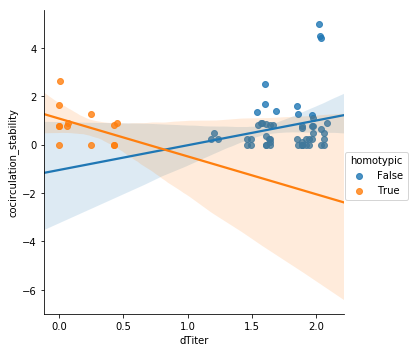

In [12]:
sns.lmplot('dTiter', 'cocirculation_stability', hue='homotypic', data=outcomes_df)

(-0.1, 1.1)

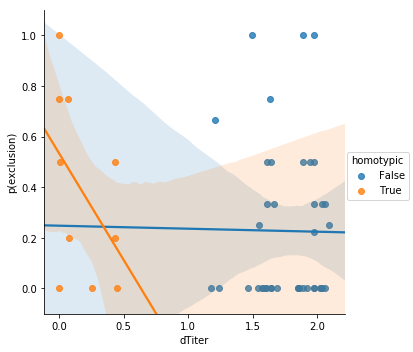

In [17]:
sns.lmplot('dTiter', 'p(exclusion)', hue='homotypic', data=outcomes_df)
plt.ylim(-.1, 1.1)

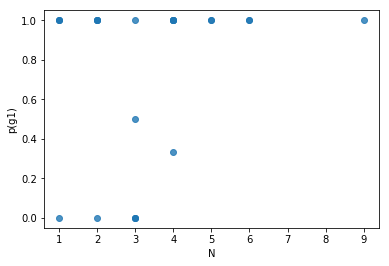

In [18]:
sns.regplot('N', 'p(g1)', data=outcomes_df, fit_reg=False)

## To investigate  
* Are the high regularlization parameters muting signal? It's a pretty sparse dataset, and the de facto priors are pretty strong.  
* We know the relationship between named genotypes : distinct antigenic phenotypes is not 1 : 1. Perhaps try binning by antigenic phenotype instead and/or in addition? (Plot subtrees for each genotype colored by cTiter to start). 

In [8]:
null_distrib = generate_null(frequencies)

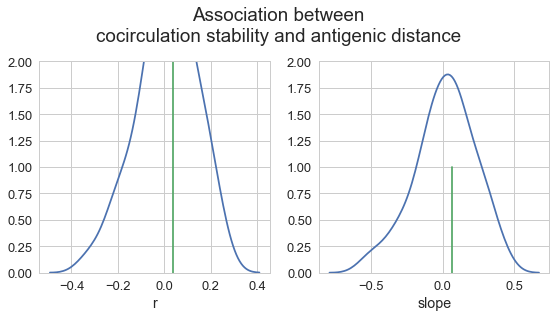

In [9]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
null_r = sns.kdeplot(pd.Series(null_distrib['r']), ax=ax[0])
null_r.plot([actual['fit']['rvalue'] for i in np.linspace(0.,2.)], [i for i in np.linspace(0.,2.)])
null_r.set_xlabel('r')
null_r.set_ylim(0, 2)

null_slope = sns.kdeplot(pd.Series(null_distrib['slope']), ax=ax[1])
null_slope.plot([actual['fit']['slope'] for i in np.linspace(0.,1.)], [i for i in np.linspace(0.,1.)])
null_slope.set_xlabel('slope')
null_slope.set_ylim(0,2)

plt.suptitle('Association between\ncocirculation stability and antigenic distance', va='bottom')
plt.tight_layout()
# plt.savefig(out_path+'/'+dataset_name+'_genotype_cocirculation_null.png')